In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import utils.plot_functions as pf
import numpy as np
from cae_model import cae

In [3]:
params = {}
#shitty hard coding
params["n_mem"] = 32768  #32768 #49152 for color, 32768 for grayscale

#general params
params["run_name"] = "7680_med_compress_pcm"
params["file_location"] = "/media/tbell/datasets/natural_images.txt"
params["gpu_ids"] = ["0"]
params["output_location"] = os.path.expanduser("~")+"/CAE_Project/CAEs/model_outputs/"+params["run_name"]
params["num_threads"] = 6
params["num_epochs"] = 40
params["epoch_size"] = 112682
params["eval_interval"] = 100
params["seed"] = 1234567890

#checkpoint params
params["run_from_check"] = False
params["check_load_run_name"] = "train"
params["check_load_path"] = "/home/dpaiton/CAE_Project/CAEs/model_outputs/"+params["check_load_run_name"]+"/checkpoints/chkpt_-22800"

#image params
params["shuffle_inputs"] = True
params["batch_size"] = 100
params["img_shape_y"] = 256
params["num_colors"] = 1
params["downsample_images"] = True
params["downsample_method"] = "resize" # can be "crop" or "resize"

#learning rates
params["init_learning_rate"] = 5.0e-4
params["decay_steps"] = 10000#epoch_size*0.5*num_epochs #0.5*epoch_size
params["staircase"] = True
params["decay_rate"] = 0.9

#layer params
params["memristorify"] = False
params["god_damn_network"] = True
params["relu"] = False

#layer dimensions
params["input_channels"] = [params["num_colors"], 128, 128]
params["output_channels"] = [128, 128, 128]
params["patch_size_y"] = [9, 5, 5]
params["strides"] = [4, 2, 2]

#memristor params
params["GAMMA"] = 1.0  # slope of the out of bounds cost
params["mem_v_min"] = -1.0
params["mem_v_max"] = 1.0
params["gauss_chan"] = False

cae_model = cae(params)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement = False # for debugging - log devices used by each variable

with tf.Session(config=config, graph=cae_model.graph) as sess:
  sess.run(cae_model.init_op)
  if cae_model.params["run_from_check"] == True:
    cae_model.full_saver.restore(sess, cae_model.params["check_load_path"])
  # Coordinator manages threads, checks for stopping requests
  coord = tf.train.Coordinator()
  # queue_runners are created by helper functions tf.train.string_input_producer() and tf.train.batch_join()
  enqueue_threads = tf.train.start_queue_runners(sess, coord=coord, start=True)

  #_, step, u_list = sess.run([cae_model.train_op, cae_model.global_step, cae_model.u_list])
  #u_vals = u_list[int(params["num_layers"]/2)]
  latent_ent_list, u_list = sess.run([cae_model.latent_entropies, cae_model.u_list])
  coord.request_stop()
  coord.join(enqueue_threads)

In [4]:
def plot_hists(latent_vals, u_vals, num_plots):
    fig, ax = plt.subplots(num_plots, figsize=(20, 5*num_plots))
    if num_plots == 1:
        ax = [ax]
    for plot in range(num_plots):
        entropy, hist, bin_edges = latent_vals[plot]
        ax[plot].scatter(bin_edges, hist)
        for index in np.arange(len(hist[:-1])):
          x_points = [bin_edges[index], bin_edges[index+1]]
          y_points = [hist[index], hist[index+1]]
          ax[plot].plot(x_points, y_points, linewidth=2, color="k")
        ax[plot].set_title("Entropy="+str(round(entropy,2)), fontsize=18)
        ylim = ax[plot].get_ylim()
        ax[plot].set_ylim((0, ylim[1]))
    plt.show()

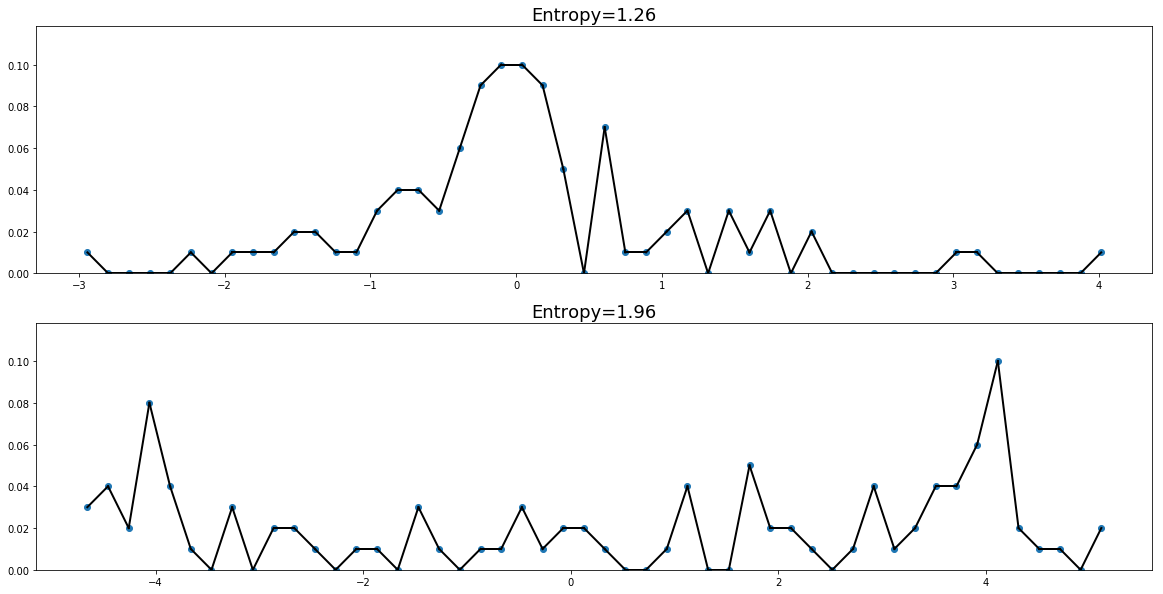

In [5]:
num_plots = 2
rand_val_index = np.random.choice(len(latent_ent_list), num_plots)
latent_vals = [latent_ent_list[idx] for idx in rand_val_index]
u_vals = tf.reshape(u_list[int(params["num_layers"]/2)], shape=(params["batch_size"], params["n_mem"]), name="u_vals")
plot_hists(latent_vals, u_vals=u_vals, num_plots=num_plots)

In [ ]:
u_vals = tf.reshape(u_list[int(params["num_layers"]/2)],
                    shape=(params["batch_size"], 
                    params["n_mem"]), 
                    name="u_vals")

In [ ]:
u_vals

In [ ]:
def get_line_eq(x_points, y_points):
    m = tf.divide(tf.subtract(y_points[1],y_points[0]),tf.subtract(x_points[1],x_points[0]))
    b = tf.subtract(y_points[1],tf.multiply(m,x_points[1]))
    return (m,b)

In [ ]:
def get_ms_and_bs(data):
    ms = []
    bs = []
    x0s = []
    x1s = []
    for xy_points in data:
        m,b = get_line_eq(xy_points[0], xy_points[1])
        ms.append(m)
        bs.append(b)
        x0s.append(xy_points[0][0])
        x1s.append(xy_points[0][1])
    return (ms, bs, x0s, x1s)

In [ ]:
def integral_end_point(x,m,b):
    m_x = tf.multiply(m,x)
    line = tf.add(m_x,b)
    two_line_sq = tf.multiply(tf.constant(2.0),tf.square(line))
    left_side = tf.multiply(two_line_sq,tf.log(line))
    
    two_b = tf.multiply(tf.constant(2.0),b)
    right_side = tf.multiply(m_x,tf.add(m_x,two_b))
    
    numerator = tf.multiply(tf.constant(-1.0),tf.subtract(left_side,right_side))
    denom = tf.multiply(tf.constant(4.0),m)
    
    return tf.divide(numerator,denom)

In [ ]:
def get_differential_entropy(x_points, y_points, m, b):
    def m_equal_0():
        def b_equal_0():
            return tf.constant(0.0)
        def b_nequal_0():
            x_1_end = tf.multiply(tf.multiply(x_points[1],tf.log(b)),tf.multiply(tf.constant(-1.0),b))
            x_0_end = tf.multiply(tf.multiply(x_points[0],tf.log(b)),tf.multiply(tf.constant(-1.0),b))
            return  tf.subtract(x_1_end,x_0_end)
        return tf.cond(tf.equal(b,tf.constant(0.0)), b_equal_0, b_nequal_0)
    def m_nequal_0():
        def y_neg():
            return tf.constant(0.0)
        def y_pos():
            return tf.subtract(integral_end_point(x_points[1],m,b),integral_end_point(x_points[0],m,b))
        return tf.cond(tf.logical_or(tf.less_equal(tf.add(tf.multiply(m,x_points[1]),b),tf.constant(0.0)),
                                     tf.less_equal(tf.add(tf.multiply(m,x_points[0]),b),tf.constant(0.0))),
                                     y_neg,y_pos)
    return tf.cond(tf.equal(m,tf.constant(0.0)), m_equal_0, m_nequal_0)

In [ ]:
x_points = [tf.constant(10.0),tf.constant(1.0)]
y_points = [tf.constant(1.0),tf.constant(1.0)]
m = tf.constant(2.0)
b = tf.constant(1.0)

In [ ]:
with tf.Session() as dat_shit:
    print (dat_shit.run(get_differential_entropy(x_points,y_points,m,b)))

In [ ]:
def compute_area(ms, bs, x0s, x1s):
    total_area=tf.constant(0.0)
    for m,b,x0,x1 in zip(ms,bs,x0s,x1s):
        left_side = tf.multiply(tf.constant(0.5),tf.multiply(m,tf.subtract(tf.square(x1),tf.square(x0))))
        rigt_side = tf.multiply(b,tf.subtract(x1,x0))        
        unit_area = tf.add(left_side,rigt_side)
        total_area = tf.add(total_area,unit_area)
    return total_area

In [ ]:
def get_normalized_points(xy_points, area, m0, b0):
    x0 = xy_points[0][0]  
    x1 = xy_points[0][1]
    x_diff = tf.subtract(x1,x0)
    x_diff_sq = tf.subtract(tf.square(x1),tf.square(x0))
    left_num = tf.add(tf.multiply(x_diff_sq,tf.multiply(tf.constant(0.5),m0)),tf.multiply(b0,x_diff))
    left_denom = tf.multiply(area,x_diff)
    left_side = tf.divide(left_num,left_denom)
    right_side = tf.divide(tf.multiply(tf.multiply(tf.constant(0.5),m0),x_diff_sq),x_diff)
    new_b = tf.subtract(left_side,right_side)
    new_y0 = tf.add(tf.multiply(m0,xy_points[0][0]),new_b)
    new_y1 = tf.add(tf.multiply(m0,xy_points[0][1]),new_b)
    new_points = [[xy_points[0][0], xy_points[0][1]], [new_y0,new_y1]]
    return new_points

In [ ]:
def bool_test(test_a,test_b):
    def true_case():
        return tf.constant("shit's true!")
    def false_case():
        return tf.constant("shit's false!")
    #num_matching = tf.reduce_sum(tf.where(tf.equal(test_a, test_b), tf.ones_like(test_a), tf.zeros_like(test_a)))
    #num_matching = tf.reduce_sum(tf.to_int32(tf.equal(test_a, test_b)))
    #return tf.cond(tf.equal(tf.constant(0),tf.shape(tf.where(tf.equal(test_a,test_b)))[0]),true_case,false_case)
    return tf.cond(tf.equal(tf.constant(0), tf.reduce_sum(tf.to_int32(tf.equal(test_a, test_b)))), true_case, false_case)

with tf.Session() as dat_shit_4:
    print(dat_shit_4.run(bool_test(tf.constant([1.0,0.0]),tf.constant([0.0,0.0]))))

In [ ]:
def unit_entropy(data, eps=None):
    ms, bs, x0s, x1s = get_ms_and_bs(data)
    area = compute_area(ms, bs, x0s, x1s)
    new_data = []
    for idx, xy_points in enumerate(data):
        m0 = ms[idx]
        b0 = bs[idx]
        xy_points = get_normalized_points(xy_points, area, m0, b0)
        new_data.append(xy_points)
    ms, bs, x0s, x1s = get_ms_and_bs(new_data)
    
    zeros_tensor = tf.constant([0.0,0.0])
    entropy = tf.constant(0.0)
    for idx, xy_points in enumerate(new_data):
        m = ms[idx]
        b = bs[idx]
    
        xy_points_tensor = xy_points[1]
    
        def points_zero_check(xy_points_tensor,zeros_tensor):
            def points_zero():
                return tf.add(entropy,tf.constant(0.0))
            def points_nzero():    
                def eps_not_None():
                    def xy_points_both_nzero():
                        return tf.add(entropy,get_differential_entropy(xy_points[0], xy_points[1], m, b))
                    def one_xy_points_nzero():
                        def xy_points_0_zero():
                            xy_points[1][0] = tf.add(xy_points[1][0],eps)
                            return tf.add(entropy,get_differential_entropy(xy_points[0], xy_points[1], m, b))
                        def xy_points_1_zero():
                            xy_points[1][1] = tf.add(xy_points[1][1],eps)
                            return tf.add(entropy,get_differential_entropy(xy_points[0], xy_points[1], m, b))
                        return tf.cond(tf.equal(xy_points[1][0],tf.constant(0.0)),
                                       xy_points_0_zero,
                                       xy_points_1_zero)   
                    return tf.cond(tf.equal(tf.constant(0),tf.shape(tf.where(tf.equal(xy_points_tensor,zeros_tensor)))[0]),
                                   xy_points_both_nzero,
                                   one_xy_points_nzero)   
                def eps_None():
                    return tf.add(entropy,get_differential_entropy(xy_points[0], xy_points[1], m, b))
                return tf.cond(tf.not_equal(eps, None), eps_not_None, eps_None)
            return tf.cond(tf.equal(tf.size(xy_points_tensor),tf.shape(tf.where(tf.equal(xy_points_tensor,zeros_tensor)))[0]),
                           points_zero,
                           points_nzero)
        entropy = tf.add(entropy, points_zero_check(xy_points_tensor,zeros_tensor))
    return entropy

In [ ]:
def var(xs,ys):
    mean_xs = tf.divide(tf.matmul(xs,tf.transpose(ys)),tf.size(xs))
    norm_mean = tf.square(tf.subtract(xs,mean_xs))
    var_xs = tf.matmul(norm_mean,tf.transpose(ys))
    return var_xs

In [ ]:
def calc_entropy(u_val, num_bins):
    value_range = [tf.reduce_min(u_val), tf.reduce_max(u_val)]
    hist = tf.histogram_fixed_width(u_val, value_range=value_range, bins=num_bins)
    bin_edges = tf.linspace(start=value_range[0], stop=value_range[1], num=num_bins)
    hist = tf.divide(hist,tf.reduce_sum(hist))
    
    for index in np.arange(len(hist[:-1])):
        x_points = [bin_edges[index], bin_edges[index+1]]
        y_points = [hist[index], hist[index+1]]
        hist_data.append((x_points, y_points))
    entropy = unit_entropy(hist_data, eps=1e-12)
    return entropy